# Equação da Difusão 2D

Vamos resolver numericamente a equação da difusão a 2D:

\begin{align*}
\frac{\partial u}{\partial t} = D \left[\frac{\partial^2u}{\partial x^2} + \frac{\partial^2u}{\partial y^2}\right]
\end{align*}

# Imports

In [17]:
# Importar as bibliotecas que vamos usar
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib.animation import PillowWriter

from PIL import Image
from typing import Callable

# Método FTCS

In [18]:
def dif2DFTCS(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dy: float, dtMult: float = 0.99) -> tuple[np.ndarray, float]:
    """
        Resolve a equação da difusão de forma aproximada usando o método FTCS, assumindo que os pontos na fronteira do domínio têm valor fixo!

        :param T: float, Tempo para evoluir a equação
        :param ci: np.ndarray, matriz com as condições iniciais
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True`
        :param D: float, coeficinte de difusão
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param dy: float, espaçamento entre pontos no eixo dos yy
        :param dtMult: float, o intervalo de tempo usado é `dtMult` * (menor dt para o qual o método é estável)

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    now = np.copy(ci)
    nex = np.copy(ci)

    # Criar o passo no tempo
    dt = 1 / (2 * D * (1/dx**2 + 1/dy**2)) * dtMult
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)
    Fy = D * dt / (dy**2)

    # Evoluir no tempo
    i = 0
    while i < iMax:
        # Passo FTCS
        nex[1:-1, 1:-1] = now[1:-1, 1:-1] + mask[1:-1, 1:-1] * (Fx * (now[1:-1, 2:] + now[1:-1, :-2] - 2 * now[1:-1, 1:-1]) +  Fy * (now[2:, 1:-1] + now[:-2, 1:-1] - 2 * now[1:-1, 1:-1]))
        
        # Avançar para a próxima iteração
        i += 1
        now = np.copy(nex)
    
    return now, i * dt

# Método BTCS

Vamos usar este método com ordenação row-major:
\begin{align*}
ij \to N_xi + j
\end{align*}

In [19]:
def dif2DBTCS(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dy: float, dt: float) -> tuple[np.ndarray, float]:
    """
        Resolve a equação da difusão de forma aproximada usando o método BTCS, assumindo que os pontos na fronteira do domínio têm valor fixo!

        :param T: float, Tempo para evoluir a equação
        :param ci: np.ndarray, matriz com as condições iniciais
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True`
        :param D: float, coeficinte de difusão
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param dy: float, espaçamento entre pontos no eixo dos yy
        :param dt: float, intervalo de tempo usado

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    Ny, Nx = ci.shape[0], ci.shape[1]
    cif = ci.flatten()
    now = np.copy(cif)
    nex = np.copy(cif)

    # Número máximo de iterações
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)
    Fy = D * dt / (dy**2)

    # Construir a matriz de coeficientes
    pontos = len(now)
    aa = sp.sparse.diags_array([(1 + 2 * Fx + 2 * Fy), -Fx, -Fx, -Fy, -Fy], offsets=[0, -1, 1, -Nx, Nx], shape=(pontos, pontos))

    # Aplicar máscara
    aa = sp.sparse.lil_matrix(aa)
    for i, line in enumerate(mask):
        for j, item in enumerate(line):
            k = i * Nx + j
            if not item:
                aa[k, (k-Nx) % pontos] = 0
                aa[k, (k-1) % pontos] = 0
                aa[k, k] = 1
                aa[k, (k+1) % pontos] = 0
                aa[k, (k+Nx) % pontos] = 0

    
    # Pré-fatorizar a matriz de coeficientes
    aa = sp.sparse.csc_matrix(aa)
    aaSolver = sp.sparse.linalg.factorized(aa)

    # Evoluir no tempo
    i = 0
    while i < iMax:
        # Passo BTCS
        nex = aaSolver(now)
            
        # Avançar para a próxima iteração
        i += 1
        now = np.copy(nex)
    
    now = np.reshape(now, (Ny, Nx))
    return now, i * dt

# Método CN
Vamos usar este método com ordenação row-major:
\begin{align*}
ij \to N_xi + j
\end{align*}

In [20]:
def dif2DCN(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dy: float, dt: float) -> tuple[np.ndarray, float]:
    """
        Resolve a equação da difusão de forma aproximada usando o método de Crank-Nicholson, assumindo que os pontos na fronteira do domínio têm valor fixo!

        :param T: float, Tempo para evoluir a equação
        :param ci: np.ndarray, matriz com as condições iniciais
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True`
        :param D: float, coeficinte de difusão
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param dy: float, espaçamento entre pontos no eixo dos yy
        :param dt: float, intervalo de tempo usado

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    Ny, Nx = ci.shape[0], ci.shape[1]
    cif = ci.flatten()
    now = np.copy(cif)
    nex = np.copy(cif)
    
    pontos = len(now)

    # Número máximo de iterações
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)
    Fy = D * dt / (dy**2)

    # Construir a matriz de coeficientes A
    aa = sp.sparse.diags_array([1 + Fx + Fy, -Fx/2, -Fx/2, -Fy/2, -Fy/2], offsets=[0, -1, 1, -Nx, Nx], shape=(pontos, pontos))

    # Aplicar máscara
    aa = sp.sparse.lil_matrix(aa)
    for i, line in enumerate(mask):
        for j, item in enumerate(line):
            k = i * Nx + j
            if not item:
                aa[k, (k-Nx) % pontos] = 0
                aa[k, (k-1) % pontos] = 0
                aa[k, k] = 1
                aa[k, (k+1) % pontos] = 0
                aa[k, (k+Nx) % pontos] = 0
    
    # Pré-fatorizar a matriz de coeficientes
    aa = sp.sparse.csc_matrix(aa)
    aaSolver = sp.sparse.linalg.factorized(aa)

    # Construir a matriz que permite obter o vetor do lado direito B
    bb = sp.sparse.diags_array([1 - Fx - Fy, Fx/2, Fx/2, Fy/2, Fy/2], offsets=[0, -1, 1, -Nx, Nx], shape=(pontos, pontos))

    # Aplicar máscara
    bb = sp.sparse.lil_matrix(bb)
    for i, line in enumerate(mask):
        for j, item in enumerate(line):
            k = i * Nx + j
            if not item:
                bb[k, (k-Nx) % pontos] = 0
                bb[k, (k-1) % pontos] = 0
                bb[k, k] = 1
                bb[k, (k+1) % pontos] = 0
                bb[k, (k+Nx) % pontos] = 0
    
    # Evoluir no tempo
    i = 0
    while i < iMax:
        nex = aaSolver(bb @ now)
            
        i += 1
        now = np.copy(nex)
    
    now = np.reshape(now, (Ny, Nx))
    return now, i * dt

# Método ADI
Vamos usar este método com ordenação row-major:
\begin{align*}
ij \to N_xi + j
\end{align*}

In [21]:
def dif2DADI(T: float, ci: np.ndarray, mask: np.ndarray, D: float, dx: float, dy: float, dt: float) -> tuple[np.ndarray, float]:
    """
        Resolve a equação da difusão de forma aproximada usando o método de Crank-Nicholson, assumindo que os pontos na fronteira do domínio têm valor fixo!

        :param T: float, Tempo para evoluir a equação
        :param ci: np.ndarray, matriz com as condições iniciais
        :param mask: np.ndarray, evolui apenas os pontos onde `mask == True`
        :param D: float, coeficinte de difusão
        :param dx: float, espaçamento entre pontos no eixo dos xx
        :param dy: float, espaçamento entre pontos no eixo dos yy
        :param dt: float, intervalo de tempo usado

        :return: tuple containing:
            - np.ndarray, vetor solução
            - float, tempo decorrido
    """

    # Copiar condições iniciais
    Ny, Nx = ci.shape[0], ci.shape[1]
    cif = ci.flatten()
    now = np.copy(cif)
    nex = np.copy(cif)
    
    pontos = len(now)

    # Aplicar a máscara
    maskf = mask.flatten()
    
    # Número máximo de iterações
    iMax = T // dt + 1

    # Calcular números de Fourier
    Fx = D * dt / (dx**2)
    Fy = D * dt / (dy**2)

    # Construir a matriz de coeficientes do primeiro meio passo
    aa1 = sp.sparse.diags_array([1 + Fx, -Fx/2, -Fx/2,], offsets=[0, -1, 1], shape=(pontos, pontos))
    aa1 = sp.sparse.csc_matrix(aa1)
    aa1Solver = sp.sparse.linalg.factorized(aa1)

    bb1 = sp.sparse.diags_array([1 - Fy, Fy/2, Fy/2], offsets=[0, -Nx, Nx], shape=(pontos, pontos))


    # Repetir para o segundo meio passo
    aa2 = sp.sparse.diags_array([1 + Fy, -Fy/2, -Fy/2,], offsets=[0, -Nx, Nx], shape=(pontos, pontos))
    aa2 = sp.sparse.csc_matrix(aa2)
    aa2Solver = sp.sparse.linalg.factorized(aa2)

    bb2 = sp.sparse.diags_array([1 - Fx, Fx/2, Fx/2], offsets=[0, -1, 1], shape=(pontos, pontos))
    
    # Evoluir no tempo
    i = 0

    # NOTA:
    # Esta forma de aplicar a máscara leva a resultados aproximados, pois fazemos cada iteração supondo que a temperatura na fronteira pode variar nessa iteração
    while i < iMax:
        nex1 = aa1Solver(bb1 @ now)
        nex = aa2Solver(bb2 @ nex1)
        nex = maskf * nex + (1 - maskf) * cif
            
        i += 1
        now = np.copy(nex)
    
    now = np.reshape(now, (Ny, Nx))
    return now, i * dt

# Testar

## Caso 1

Vamos considerar a função:

$$
u(x, y, t) = \sin\left(2\pi \frac{x}{L_x}\right)\sin\left(2\pi \frac{y}{L_y}\right)\exp\left(-t\left[\left(\frac{2\pi}{L_x}\right)^2 + \left(\frac{2\pi}{L_y}\right)^2\right]\right)
$$

Temos que:
$$
\nabla^2u = -\left[\left(\frac{2\pi}{L_x}\right)^2 + \left(\frac{2\pi}{L_y}\right)^2\right]u(x, y) = \frac{\partial u}{\partial t}
$$

Podemos então resolver a equação do calor com condição inicial dada por $u(x, y, 0)$ e condição fronteira $u = 0$ em todo o bordo e comparar com a solução analítica!

In [22]:
# Criar o problema
Lx = 1
Ly = 1

# Parâmetros
Nx = 151
Ny = 91

Nt = 2001
Tmax = 0.1

dx = Lx / (Nx - 1)
dy = Ly / (Ny - 1)
dt = Tmax / (Nt - 1)

ci = np.zeros((Ny, Nx))
mask = np.full((Ny, Nx), True)

# Condições do problema (a fronteira é só a borda da caixa)
for i in range(Ny):
    for j in range(Nx):
        if i in [0, Ny-1] or j in [0, Nx-1]:
            mask[i, j] = False


A = 10000
k = 1
def u(x, y, t):
    return A * np.sin(k * 2*np.pi * x / Lx) * np.sin(k * 2*np.pi * y / Ly) * np.exp(-t * ((k * 2*np.pi / Lx)**2 + (k * 2*np.pi / Ly)**2))


xx = np.linspace(0, Lx, Nx)
yy = np.linspace(0, Ly, Ny)

mx, my = np.meshgrid(xx, yy)

ci = u(mx, my, 0)

### Método FTCS

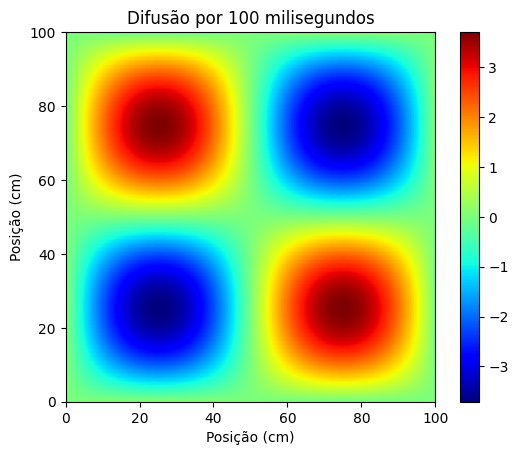

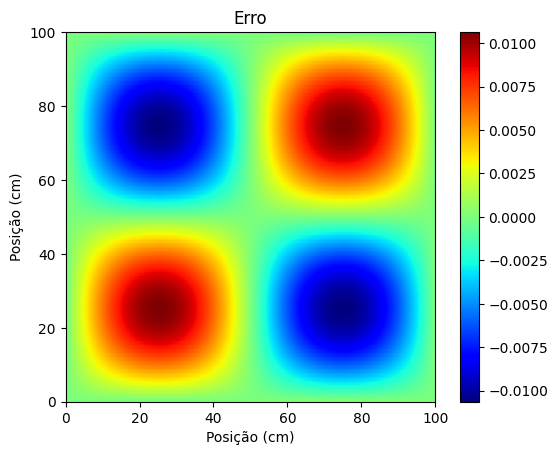

In [23]:
# Fazer a simulação
sol, tem = dif2DFTCS(Tmax, ci, mask, 1, dx, dy)


# Mostrar a solução
plt.imshow(sol, extent=(0, Lx*100, 0, Ly*100), cmap="jet")
plt.colorbar()
plt.title(f"Difusão por {tem*1000:.0f} milisegundos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

# Comparar com a solução exata
plt.imshow(sol - u(mx, my, tem), extent=(0, Lx*100, 0, Ly*100), cmap="jet")
plt.colorbar()
plt.title("Erro")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

### Método BTCS

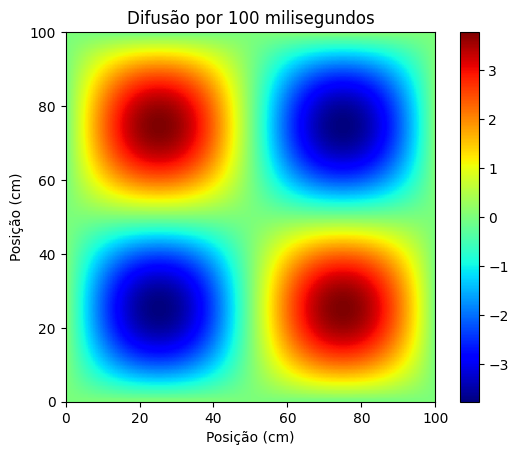

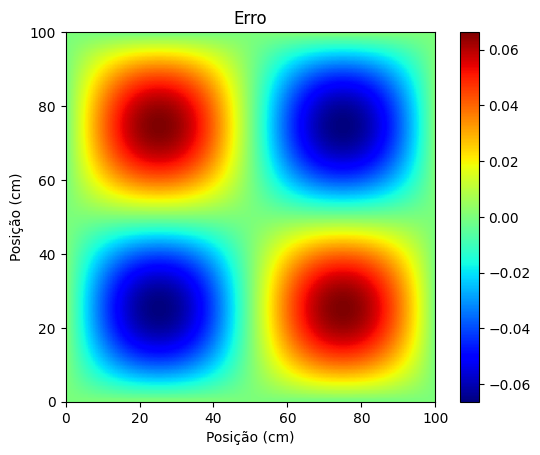

In [24]:
# Fazer a simulação
sol, tem = dif2DBTCS(Tmax, ci, mask, 1, dx, dy, dt)


# Mostrar a solução
plt.imshow(sol, extent=(0, Lx*100, 0, Ly*100), cmap="jet")
plt.colorbar()
plt.title(f"Difusão por {tem*1000:.0f} milisegundos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

# Comparar com a solução exata
plt.imshow(sol - u(mx, my, tem), extent=(0, Lx*100, 0, Ly*100), cmap="jet")
plt.colorbar()
plt.title("Erro")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

### Método CN

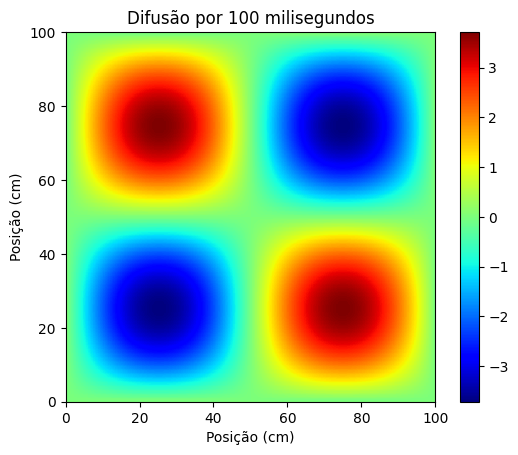

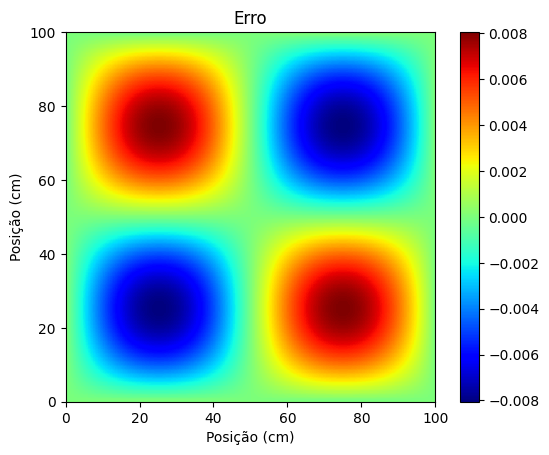

In [25]:
# Fazer a simulação
sol, tem = dif2DCN(Tmax, ci, mask, 1, dx, dy, dt)


# Mostrar a solução
plt.imshow(sol, extent=(0, Lx*100, 0, Ly*100), cmap="jet")
plt.colorbar()
plt.title(f"Difusão por {tem*1000:.0f} milisegundos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

# Comparar com a solução exata
plt.imshow(sol - u(mx, my, tem), extent=(0, Lx*100, 0, Ly*100), cmap="jet")
plt.colorbar()
plt.title("Erro")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

### Método ADI

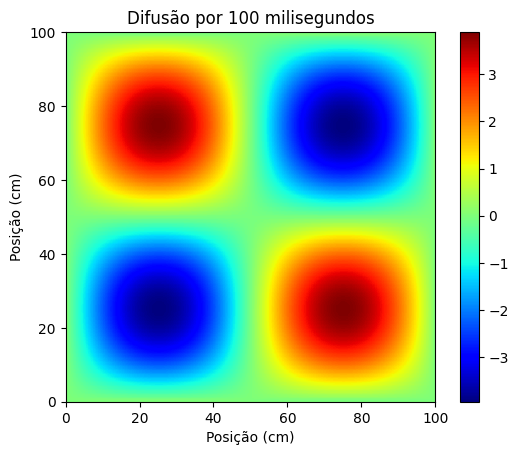

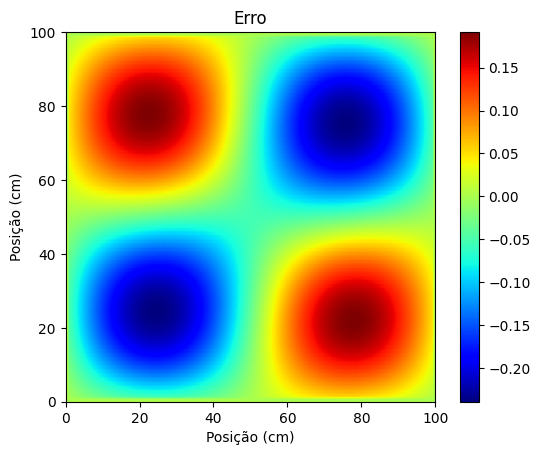

In [26]:
# Fazer a simulação
sol, tem = dif2DADI(Tmax, ci, mask, 1, dx, dy, dt)


# Mostrar a solução
plt.imshow(sol, extent=(0, Lx*100, 0, Ly*100), cmap="jet")
plt.colorbar()
plt.title(f"Difusão por {tem*1000:.0f} milisegundos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

# Comparar com a solução exata
plt.imshow(sol - u(mx, my, tem), extent=(0, Lx*100, 0, Ly*100), cmap="jet")
plt.colorbar()
plt.title("Erro")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

## Caso 2 - Leitão

Vamos aquecer um leitão!

In [27]:
# Parâmetros do Problema (Unidades SI, Temperatura em Celsius)

# Dimensões e Temperatura do Forno
FORNOX = 0.60
FORNOY = 0.60
FORNOT = 150

# Dimensões e Temperatura do Leitão
LEITAOX = 0.45
LEITAOTI = 6
LEITAOTF = 70

# Coeficiente de difusão
DIF = 1.45e-7


# Parâmetros da Simulação

# Número de pontos a usar
NX = 501
NY = 501

# Espaçamento entre pontos da grelha
DX = FORNOX / (NX-1)
DY = FORNOY / (NY-1)

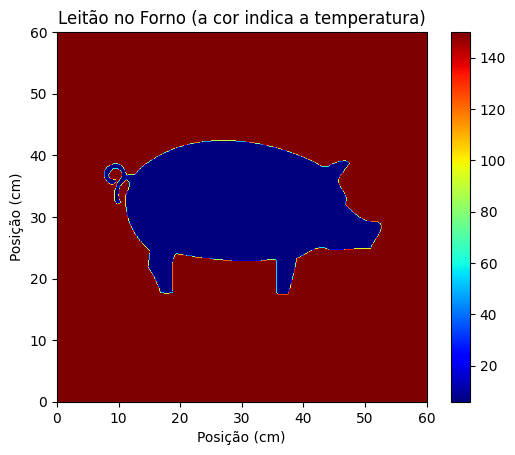

In [28]:
# Importar a imagem
leitao = Image.open("leitao_bw.png")

# Tamanho da imagem
XMAX, YMAX = leitao.size
LEITAOY = LEITAOX * (YMAX / XMAX)

# Espaçamento entre pontos da grelha da imagem do leitão
NXLEITAO = int(LEITAOX / FORNOX * NX)
NYLEITAO = int(LEITAOY / FORNOY * NY)

DXLEITAO = LEITAOX / (NXLEITAO - 1)
DYLEITAO = LEITAOY / (NYLEITAO - 1)

# Transformar em array
ll = np.array(leitao)

# Posicionamos o leitão de forma a que fique no centro do forno
NXI = (NX - NXLEITAO) // 2
NYI = (NY - NYLEITAO) // 2

XI = NXI * DX
YI = NYI * DY

# Interpolar a imagem png para obter a resolução desejada
xx = np.arange(XMAX)
yy = np.arange(YMAX)
coords = []

MULTX = DXLEITAO * NXLEITAO / XMAX
MULTY = DYLEITAO * NYLEITAO / YMAX
for i in range(XMAX):
    for j in range(YMAX):
        coords += [(XI + i * MULTX, YI + j * MULTY)]

interpol = sp.interpolate.LinearNDInterpolator(coords, ll.flatten(order="F"), fill_value=0)

# Colocar o leitão dentro do forno e definir a grelha
xx = np.linspace(0, FORNOX, NX)
yy = np.linspace(0, FORNOY, NY)
mx, my = np.meshgrid(xx, yy)
ll = interpol(mx, my)

# Fazer a máscara que indica onde está o leitão
leitao = ll > 240

# Aplicar as condições iniciais (que incluem as condições fronteira graças a máscara que criamos)
forno = np.zeros_like(ll)
forno[:, :] = FORNOT
forno[leitao] = LEITAOTI

# Ver a imagem
plt.imshow(forno, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title("Leitão no Forno (a cor indica a temperatura)")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

## Método FTCS

In [29]:
# Vamos apenas simular a parte do forno que interessa (forno e máscara Cortadas)
dN = 6 # Margem de segurança para evitar cortar o leitão
fornoC, leitaoC = forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)], leitao[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)]

# Fazer a simulação
cozinhado, tempo = dif2DFTCS(5 * 3600, fornoC, leitaoC, DIF, DX, DY)

# Desfazer o recorte
fornoF = np.copy(forno)
fornoF[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)] = cozinhado

plt.imshow(fornoF, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title(f"Leitão no Forno após {tempo/60:.1f} minutos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

KeyboardInterrupt: 

## Método BTCS

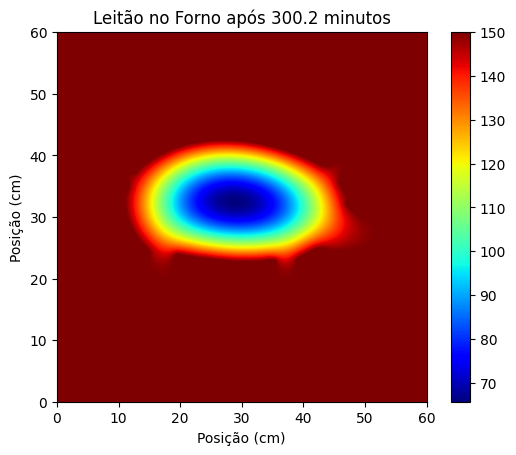

In [ ]:
# Vamos apenas simular a parte do forno que interessa (forno e máscara Cortadas)
dN = 6 # Margem de segurança para evitar cortar o leitão
fornoC, leitaoC = forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)], leitao[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)]

# Fazer a simulação
cozinhado, tempo = dif2DBTCS(5 * 3600, fornoC, leitaoC, DIF, DX, DY, 10)

# Desfazer o recorte
fornoF = np.copy(forno)
fornoF[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)] = cozinhado

plt.imshow(fornoF, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title(f"Leitão no Forno após {tempo/60:.1f} minutos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

## Método CN

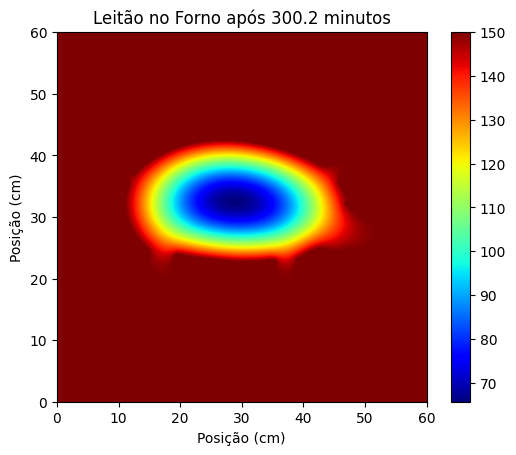

In [ ]:
# Vamos apenas simular a parte do forno que interessa (forno e máscara Cortadas)
dN = 6 # Margem de segurança para evitar cortar o leitão
fornoC, leitaoC = forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)], leitao[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)]

# Fazer a simulação
cozinhado, tempo = dif2DCN(5 * 3600, fornoC, leitaoC, DIF, DX, DY, 10)

# Desfazer o recorte
fornoF = np.copy(forno)
fornoF[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)] = cozinhado

plt.imshow(fornoF, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title(f"Leitão no Forno após {tempo/60:.1f} minutos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()

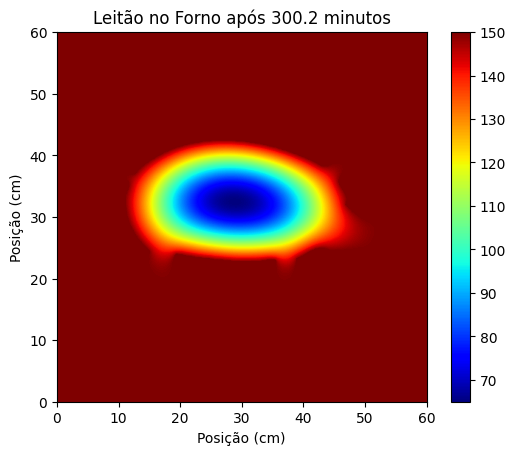

In [ ]:
# Vamos apenas simular a parte do forno que interessa (forno e máscara Cortadas)
dN = 6 # Margem de segurança para evitar cortar o leitão
fornoC, leitaoC = forno[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)], leitao[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)]

# Fazer a simulação
cozinhado, tempo = dif2DADI(5 * 3600, fornoC, leitaoC, DIF, DX, DY, 10)

# Desfazer o recorte
fornoF = np.copy(forno)
fornoF[(NYI - dN):-(NYI - dN), (NXI - dN):-(NXI - dN)] = cozinhado

plt.imshow(fornoF, extent=(0, FORNOX / 0.01, 0, FORNOY / 0.01), cmap="jet")
plt.colorbar()
plt.title(f"Leitão no Forno após {tempo/60:.1f} minutos")
plt.xlabel('Posição (cm)')
plt.ylabel('Posição (cm)')
plt.show()